<a href="https://colab.research.google.com/github/AI4Finance-LLC/FinRL-Library/blob/master/FinRL_multiple_stock_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a id='1.2'></a>
## 2.2. Check if the additional packages needed are present, if not install them. 
* Yahoo Finance API
* pandas
* numpy
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow
* pyfolio

In [1]:
import sys


sys.path.append("../FinRL-Library")

<a id='1.3'></a>
## 2.3. Import Packages

In [33]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config import config
from finrl.marketdata.yahoodownloader import YahooDownloader
from finrl.preprocessing.preprocessors import FeatureEngineer
from finrl.preprocessing.data import data_split
from finrl.env.env_multistock import MultistockEnv
from finrl.model.models import DRLAgent
from finrl.trade.backtest import BackTestStats, BaselineStats, BackTestPlot

from pprint import pprint

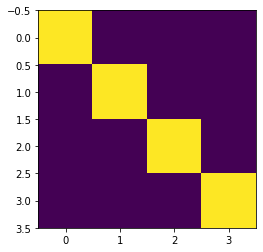

In [34]:
fig,ax = plt.subplots(1)
ax.imshow(np.eye(4))
plt.show()

<a id='1.4'></a>
## 2.4. Create Folders

In [4]:
import os
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [5]:
# from config.py start_date is a string
config.START_DATE = "2018-01-01"

In [6]:
# from config.py end_date is a string
config.END_DATE
print(f"start: {config.START_DATE}, end: {config.END_DATE}")

start: 2018-01-01, end: 2020-12-01


In [7]:
pprint(config.DOW_30_TICKER[:5])

['AAPL', 'MSFT', 'JPM', 'V', 'RTX']


In [8]:
df = YahooDownloader(start_date = config.START_DATE,
                     end_date = config.END_DATE,
                     ticker_list = config.DOW_30_TICKER[:5]).fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3670, 7)


In [9]:
df.shape

(3670, 7)

In [10]:
df.sort_values(['date','tic'],ignore_index=True).head()

,date,open,high,low,close,volume,tic
0,2018-01-02,42.540001,43.075001,42.314999,41.442081,102223600,AAPL
1,2018-01-02,107.629997,108.019997,106.809998,98.750923,13578800,JPM
2,2018-01-02,86.129997,86.309998,85.500000,82.383636,22483800,MSFT
3,2018-01-02,80.490875,81.107613,80.031464,74.994568,4918500,RTX
4,2018-01-02,114.570000,115.080002,113.949997,112.335358,6080900,V


In [11]:
fe = FeatureEngineer(use_technical_indicator=True,
                    tech_indicator_list = config.TECHNICAL_INDICATORS_LIST,
                    use_turbulence=True,
                    user_defined_feature = False)


processed = fe.preprocess_data(df)

Successfully added technical indicators
Successfully added turbulence index


In [12]:
print(type(processed))

<class 'pandas.core.frame.DataFrame'>


In [13]:
processed.sort_values(['date','tic'],ignore_index=True).head(10)

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2018-01-02,42.540001,43.075001,42.314999,41.442081,102223600,AAPL,0.000000,0.0,66.666667,100.0,0.0
1,2018-01-02,107.629997,108.019997,106.809998,98.750923,13578800,JPM,0.000000,0.0,66.666667,100.0,0.0
2,2018-01-02,86.129997,86.309998,85.500000,82.383636,22483800,MSFT,0.000000,0.0,66.666667,100.0,0.0
3,2018-01-02,80.490875,81.107613,80.031464,74.994568,4918500,RTX,0.000000,0.0,66.666667,100.0,0.0
4,2018-01-02,114.570000,115.080002,113.949997,112.335358,6080900,V,0.000000,0.0,66.666667,100.0,0.0
5,2018-01-03,43.132500,43.637501,42.990002,41.434864,118071600,AAPL,-0.000162,0.0,66.666667,100.0,0.0
6,2018-01-03,107.860001,108.489998,107.480003,98.851555,11901000,JPM,0.002258,100.0,66.666667,100.0,0.0
7,2018-01-03,86.059998,86.510002,85.970001,82.767044,26061400,MSFT,0.008602,100.0,66.666667,100.0,0.0
8,2018-01-03,81.491501,81.938324,81.384521,76.094666,7958900,RTX,0.024682,100.0,66.666667,100.0,0.0
9,2018-01-03,114.949997,115.790001,114.660004,113.453690,6946100,V,0.025091,100.0,66.666667,100.0,0.0


In [14]:
train = data_split(processed, '2009-01-01','2019-01-01')
trade = data_split(processed, '2019-01-01','2020-12-01')
print(len(train))
print(len(trade))


1255
2415


In [15]:
train.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2018-01-02,42.540001,43.075001,42.314999,41.442081,102223600,AAPL,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,107.629997,108.019997,106.809998,98.750923,13578800,JPM,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,86.129997,86.309998,85.500000,82.383636,22483800,MSFT,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,80.490875,81.107613,80.031464,74.994568,4918500,RTX,0.0,0.0,66.666667,100.0,0.0
0,2018-01-02,114.570000,115.080002,113.949997,112.335358,6080900,V,0.0,0.0,66.666667,100.0,0.0


In [16]:
trade.head()

,date,open,high,low,close,volume,tic,macd,rsi_30,cci_30,dx_30,turbulence
0,2019-01-02,38.722500,39.712502,38.557499,38.562561,148158800,AAPL,-2.019903,37.865996,-91.567852,42.250809,0.0
0,2019-01-02,95.949997,99.779999,95.940002,92.928543,15670900,JPM,-2.599788,43.026559,-61.120190,16.147419,0.0
0,2019-01-02,99.550003,101.750000,98.940002,98.602066,35329300,MSFT,-1.908755,45.768318,-81.402190,21.611852,0.0
0,2019-01-02,66.179985,68.187538,65.601006,64.796608,9361700,RTX,-2.988610,36.797678,-109.397938,44.007807,0.0
0,2019-01-02,130.000000,133.740005,129.600006,131.264542,8788000,V,-2.114526,47.277723,-46.722946,11.039625,0.0


In [17]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(config.TECHNICAL_INDICATORS_LIST)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 5, State Space: 31


In [18]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 100000, 
    "transaction_cost_pct": 0.003, 
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
    
}

e_train_gym = MultistockEnv(df = train, **env_kwargs)

e_trade_gym = MultistockEnv(df = trade, turbulence_threshold = 250, **env_kwargs)

In [29]:


env_train, _ = e_train_gym.get_sb_env()


env_trade, obs_trade = e_trade_gym.get_sb_env()

In [20]:
print(type(env_train))

<class 'stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv'>


In [21]:
type(config)
config.__dict__['DDPG_PARAMS']


{'batch_size': 128, 'buffer_size': 50000, 'learning_rate': 0.001}

In [22]:
da = DRLAgent(env = env_train)


model = da.get_model("ppo", verbose = 0)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 64}


/opt/conda/lib/python3.6/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU1 GeForce GTX 760 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [23]:
trained = da.train_model(model, 'ppo2', total_timesteps = 10)

day: 250, episode: 0
begin_total_asset:100000.00
end_total_asset:79853.94
total_reward:-20146.06
total_cost: 12500.24
total_trades: 1129
Sharpe: -0.989


### Model Training: 5 models, A2C DDPG, PPO, TD3, SAC


### Model 1: A2C


### Model 2: DDPG

## Trading
Assume that we have $1,000,000 initial capital at 2019-01-01. We use the DDPG model to trade Dow jones 30 stocks.

### Set turbulence threshold
Set the turbulence threshold to be the 99% quantile of insample turbulence data, if current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [24]:
data_turbulence = processed[(processed.date<'2019-01-01') & (processed.date>='2009-01-01')]
insample_turbulence = data_turbulence.drop_duplicates(subset=['date'])

In [25]:
insample_turbulence.turbulence.describe()

count    251.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: turbulence, dtype: float64

In [26]:
turbulence_threshold = np.quantile(insample_turbulence.turbulence.values,1)

In [27]:
turbulence_threshold

0.0

### Trade

DRL model needs to update periodically in order to take full advantage of the data, ideally we need to retrain our model yearly, quarterly, or monthly. We also need to tune the parameters along the way, in this notebook I only use the in-sample data from 2009-01 to 2018-12 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [30]:

df_account_value, df_actions = DRLAgent.DRL_prediction(model=model,
                        test_data = trade,
                        test_env = env_trade,
                        test_obs = obs_trade)

day: 482, episode: 0
begin_total_asset:100000.00
end_total_asset:108055.25
total_reward:8055.25
total_cost: 31358.54
total_trades: 2190
Sharpe: 0.286


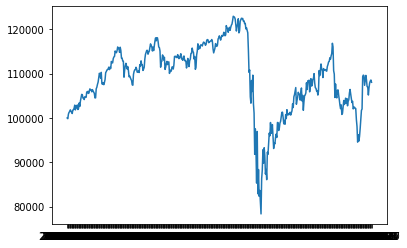

In [35]:
df_account_value.head()
plt.plot(df_account_value.date, df_account_value.account_value)

In [36]:
df_actions

,AAPL,JPM,MSFT,RTX,V
date,,,,,
2019-01-02,39.593262,-28.552124,-9.189999,-68.350449,-100.000000
2019-01-03,-5.430490,100.000000,-100.000000,86.826912,100.000000
2019-01-04,-100.000000,-11.466573,100.000000,-65.176300,100.000000
2019-01-07,64.068611,-100.000000,100.000000,-67.143562,-91.649422
2019-01-08,-19.227795,-100.000000,-4.296690,49.474041,-51.144005
...,...,...,...,...,...
2020-11-20,-66.412033,24.726509,53.337265,62.473522,98.801407
2020-11-23,-100.000000,-56.716019,35.643593,-66.046440,-28.025562
2020-11-24,-12.273953,-4.733563,100.000000,33.796120,89.760460


In [37]:
df_account_value.shape

(483, 2)

In [38]:
df_account_value.head()

,date,account_value
0,2019-01-02,100000.000000
1,2019-01-03,99843.337465
2,2019-01-04,100878.581504
3,2019-01-07,101283.540112
4,2019-01-08,101448.009999


<a id='6'></a>
# Part 7: Backtest Our Strategy
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [39]:
print("==============Get Backtest Results===========")
perf_stats_all = BackTestStats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
# perf_stats_all.to_csv("./"+config.RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
annual return:  8.898045427813873
sharpe ratio:  0.28550520752795167
Annual return          0.041248
Cumulative returns     0.080553
Annual volatility      0.298616
Sharpe ratio           0.285505
Calmar ratio           0.113739
Stability              0.064197
Max drawdown          -0.362659
Omega ratio            1.065088
Sortino ratio          0.397887
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.770758
Daily value at risk   -0.037284
Alpha                  0.000000
Beta                   1.000000
dtype: float64


<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
annual return:  8.898045427813873
sharpe ratio:  0.28550520752795167
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)


Start date,2019-01-03
End date,2020-11-30
Total months,22
,Backtest
Annual return,4.134%
Cumulative returns,8.055%
Annual volatility,29.862%
Sharpe ratio,0.29
Calmar ratio,0.11
Stability,0.06
Max drawdown,-36.266%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,36.27,2020-01-17,2020-03-23,NaT,NaN
1,7.44,2019-04-29,2019-06-03,2019-07-12,55
2,6.82,2019-07-26,2019-08-23,2019-12-16,102
3,2.52,2019-03-21,2019-03-27,2019-04-02,9
4,1.90,2019-02-25,2019-03-07,2019-03-11,11


/opt/conda/lib/python3.6/site-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


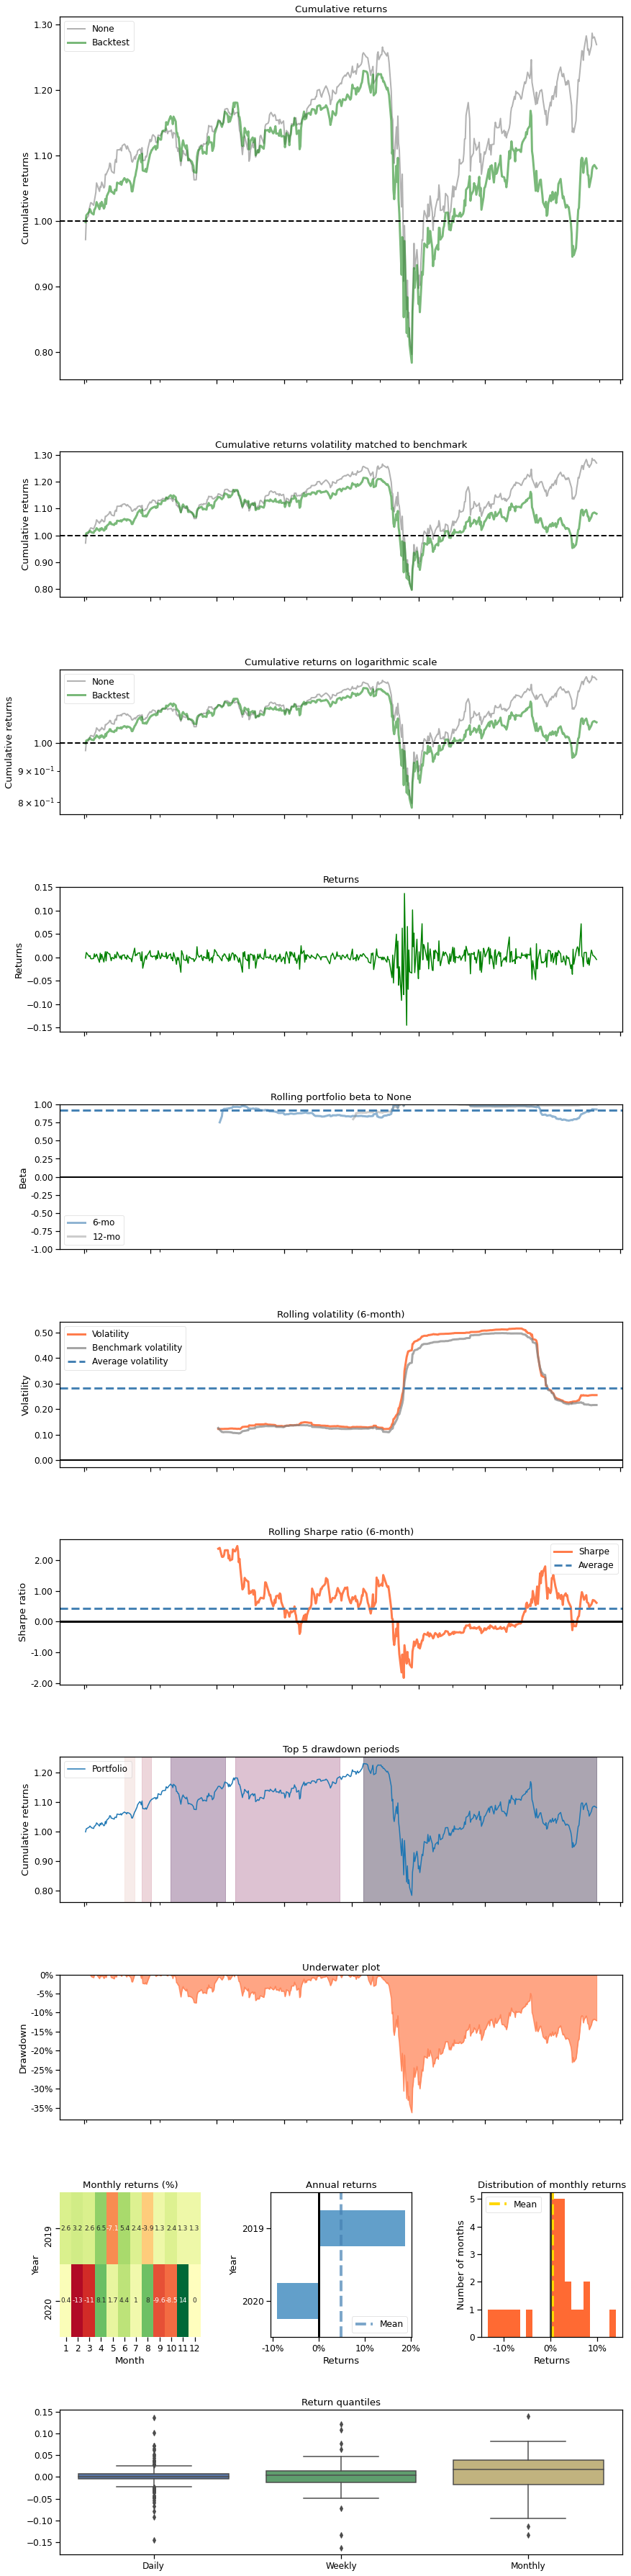

In [40]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
BackTestPlot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = '2019-01-01',
             baseline_end = '2020-12-01')

<a id='6.3'></a>
## 7.3 Baseline Stats

In [41]:
print("==============Get Baseline Stats===========")
baesline_perf_stats=BaselineStats('^DJI',
                                  baseline_start = '2019-01-01',
                                  baseline_end = '2020-12-01')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (483, 7)
Annual return          0.132593
Cumulative returns     0.269525
Annual volatility      0.280347
Sharpe ratio           0.586312
Calmar ratio           0.357526
Stability              0.060828
Max drawdown          -0.370862
Omega ratio            1.137261
Sortino ratio          0.807330
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.844803
Daily value at risk   -0.034668
Alpha                  0.000000
Beta                   1.000000
dtype: float64
